In [ ]:
import sys

# change local PATH environment for Python
# sys.path.append('/nfs/optimi/usr/sw/cplex/python/3.6/x86-64_linux')

import cplex
import networkx as nx
import time
import re
from scipy import *
from scipy.sparse import *
import numpy as np
#import Logger  # print out to file
from datetime import datetime, timedelta
from dateutil.parser import parse
import matplotlib.pyplot as plt

from tools import *
from OD_matrix import *

# networkx start
graph = nx.DiGraph() # nx.MultiDiGraph()

inspectors = { 0 : {"base": 'RDRM', "working_hours": 8, "rate": 12},
              1 : {"base": 'HH', "working_hours": 5, "rate": 10},
              2 : {"base": 'AHAR', "working_hours": 6, "rate": 15}}

flow_var_names = []

# dictionary with keys being var_M and values being upper-bounds
var_passengers_inspected = {}
# new reformulation variable
# has length = # of types of passengers
# need to enumerate types of passengers
# keys are var_M and values are upper bounds which should all be 1
var_portion_of_passengers_inspected = np.array([])

HOUR_TO_SECONDS = 3600
MINUTE_TO_SECONDS = 60


input_dir = '../hai_code/Mon_Arcs.txt' # /home/optimi/bzfnguye/grips-2019

#============================= CONSTRUCTING THE GRAPH ============================================

print("Building graph ...", end = " ")
t1 = time.time()

# build_graph(input_dir, graph, inspectors, flow_var_names, var_passengers_inspected)

with open(input_dir, "r") as f:
    for line in f.readlines()[:-1]:
        line = line.replace('\n','').split(' ')
        start = line[0]+'@'+line[1]
        end = line[2]+'@'+line[3]

        for k in inspectors:
            flow_var_names.append('var_x_{}_{}_{}'.format(start, end, k))

        var_passengers_inspected['var_M_{}_{}'.format(start, end)] = int(line[4])

        graph.add_node(start, station = line[0], time_stamp = line[1])
        graph.add_node(end, station = line[2], time_stamp = line[3])

        # we assume a unique edge between events for now
        if not graph.has_edge(start, end):
            graph.add_edge(start, end, num_passengers= int(line[4]), travel_time =int(line[5]))


# time to build graph
t2 = time.time()

print('Finished! Took {:.5f} seconds'.format(t2-t1))

#================================ OD Estimation ===============================
print("Estimating OD Matrix ...", end = " ")

T, OD = generate_OD_matrix(graph)

# preliminary data needed
all_paths, path_idx = enumerate_all_shortest_paths(graph)

# create variable names
for (source, sink), value in all_paths.items():
    var_portion_of_passengers_inspected = np.append(var_portion_of_passengers_inspected, 'portion_of_({},{})'.format(source, sink))

t2a = time.time()
# print(new_weights)
print('Finished! Took {:.5f} seconds'.format(t2a-t2))

#============================== ADDING SOURCE/SINK NODES ==========================================

print("Adding Sinks/Sources...", end=" ")

# add_sources_and_sinks(graph, inspectors, flow_var_names, var_passengers_inspected)
for k, vals in inspectors.items():
    source = "source_" + str(k)
    sink = "sink_"+str(k)
    graph.add_node(source, station = vals['base'], time_stamp = None)
    graph.add_node(sink, station = vals['base'], time_stamp = None)
    for node in graph.nodes():
        if (graph.nodes[node]['station'] == vals['base']) and (graph.nodes[node]['time_stamp'] is not None):

            # adding edge between sink and events and adding to the variable dictionary
            graph.add_edge(source, node, num_passengers = 0, travel_time = 0)
            flow_var_names.append('var_x_{}_{}_{}'.format(source, node, k))
            var_passengers_inspected['var_M_{}_{}'.format(source, node)] = 0
            graph.add_edge(node, sink, num_passengers=0, travel_time = 0 )
            flow_var_names.append('var_x_{}_{}_{}'.format(node, sink, k))
            var_passengers_inspected['var_M_{}_{}'.format(node, sink)] = 0


t3 = time.time()

print('Finished! Took {:.5f} seconds'.format(t3-t2a))

# test edge source to sinks
# print('TEST: Unique edge between two nodes: ', num_edges == graph.number_of_edges())
print("TEST: No Source-Sink Edge: ", not graph.has_edge("source_0", "sink_0"))

# freeze graph to prevent further changes
graph = nx.freeze(graph)

print('successors of FFU@10:51:00')

for node in graph.successors('FFU@10:51:00'):
    print(node)

#================================== START CPLEX =================================================

print("Start CPLEX")

c = cplex.Cplex()

# start_cplex(c, flow_var_names, var_passengers_inspected)
# initialize_cplex(c, OD, flow_var_names, var_portion_of_passengers_inspected)
c.set_problem_type(c.problem_type.LP)
c.objective.set_sense(c.objective.sense.maximize)	# formulated as a maximization problem


#========================= ADDING VARIABLES AND OBJECTIVE FUNCTION ==============================

print("Adding variables...", end=" ")

# adding objective function and declaring variable types
c.variables.add(
    names = flow_var_names,
    types = [ c.variables.type.binary ] * len(flow_var_names)
)

# defining the objective function coefficients
obj = [OD[(source, sink)] for source, sink in OD.keys()]

In [ ]:
len(all_paths)

In [ ]:
c.variables.add(
    names = var_portion_of_passengers_inspected,
    lb = [0] * len(var_portion_of_passengers_inspected),
    ub = [1] * len(var_portion_of_passengers_inspected),
    obj = obj,
    types = [ c.variables.type.continuous ] * len(var_portion_of_passengers_inspected)
)

In [ ]:
len(obj)

In [ ]:
len(var_portion_of_passengers_inspected)

In [ ]:
len(OD)

In [ ]:
len(all_paths)

In [ ]:
OD.size()

In [ ]:
all_paths

In [ ]:
clear()

In [ ]:
all_paths

In [ ]:
quit()

In [ ]:
# Input: Data file in Forward Star format
# Output: Digraph object
# Function: This file will be used to read in information to
# create the DiGraph object and write it to another file
# @author: Ruby Abrams, Hai Nguyen

import sys

# change local PATH environment for Python
# sys.path.append('/nfs/optimi/usr/sw/cplex/python/3.6/x86-64_linux')

import cplex
import networkx as nx
import time
import re
from scipy import *
from scipy.sparse import *
import numpy as np
#import Logger  # print out to file
from datetime import datetime, timedelta
from dateutil.parser import parse
import matplotlib.pyplot as plt

from tools import *
from OD_matrix import *

# networkx start
graph = nx.DiGraph() # nx.MultiDiGraph()

inspectors = { 0 : {"base": 'RDRM', "working_hours": 8, "rate": 12},
              1 : {"base": 'HH', "working_hours": 5, "rate": 10},
              2 : {"base": 'AHAR', "working_hours": 6, "rate": 15}}

flow_var_names = []

# dictionary with keys being var_M and values being upper-bounds
var_passengers_inspected = {}
# new reformulation variable
# has length = # of types of passengers
# need to enumerate types of passengers
# keys are var_M and values are upper bounds which should all be 1
var_portion_of_passengers_inspected = np.array([])

HOUR_TO_SECONDS = 3600
MINUTE_TO_SECONDS = 60


input_dir = '../hai_code/Mon_Arcs.txt' # /home/optimi/bzfnguye/grips-2019

#============================= CONSTRUCTING THE GRAPH ============================================

print("Building graph ...", end = " ")
t1 = time.time()

# build_graph(input_dir, graph, inspectors, flow_var_names, var_passengers_inspected)

with open(input_dir, "r") as f:
    for line in f.readlines()[:-1]:
        line = line.replace('\n','').split(' ')
        start = line[0]+'@'+line[1]
        end = line[2]+'@'+line[3]

        for k in inspectors:
            flow_var_names.append('var_x_{}_{}_{}'.format(start, end, k))

        var_passengers_inspected['var_M_{}_{}'.format(start, end)] = int(line[4])

        graph.add_node(start, station = line[0], time_stamp = line[1])
        graph.add_node(end, station = line[2], time_stamp = line[3])

        # we assume a unique edge between events for now
        if not graph.has_edge(start, end):
            graph.add_edge(start, end, num_passengers= int(line[4]), travel_time =int(line[5]))


# time to build graph
t2 = time.time()

print('Finished! Took {:.5f} seconds'.format(t2-t1))

#================================ OD Estimation ===============================
print("Estimating OD Matrix ...", end = " ")

T, OD = generate_OD_matrix(graph)

# preliminary data needed
all_paths, path_idx = enumerate_all_shortest_paths(graph)

# create variable names
for (source, sink), value in all_paths.items():
    var_portion_of_passengers_inspected = np.append(var_portion_of_passengers_inspected, 'portion_of_({},{})'.format(source, sink))

t2a = time.time()
# print(new_weights)
print('Finished! Took {:.5f} seconds'.format(t2a-t2))

#============================== ADDING SOURCE/SINK NODES ==========================================

print("Adding Sinks/Sources...", end=" ")

# add_sources_and_sinks(graph, inspectors, flow_var_names, var_passengers_inspected)
for k, vals in inspectors.items():
    source = "source_" + str(k)
    sink = "sink_"+str(k)
    graph.add_node(source, station = vals['base'], time_stamp = None)
    graph.add_node(sink, station = vals['base'], time_stamp = None)
    for node in graph.nodes():
        if (graph.nodes[node]['station'] == vals['base']) and (graph.nodes[node]['time_stamp'] is not None):

            # adding edge between sink and events and adding to the variable dictionary
            graph.add_edge(source, node, num_passengers = 0, travel_time = 0)
            flow_var_names.append('var_x_{}_{}_{}'.format(source, node, k))
            var_passengers_inspected['var_M_{}_{}'.format(source, node)] = 0
            graph.add_edge(node, sink, num_passengers=0, travel_time = 0 )
            flow_var_names.append('var_x_{}_{}_{}'.format(node, sink, k))
            var_passengers_inspected['var_M_{}_{}'.format(node, sink)] = 0


t3 = time.time()

print('Finished! Took {:.5f} seconds'.format(t3-t2a))

# test edge source to sinks
# print('TEST: Unique edge between two nodes: ', num_edges == graph.number_of_edges())
print("TEST: No Source-Sink Edge: ", not graph.has_edge("source_0", "sink_0"))

# freeze graph to prevent further changes
graph = nx.freeze(graph)

print('successors of FFU@10:51:00')

for node in graph.successors('FFU@10:51:00'):
    print(node)

#================================== START CPLEX =================================================

print("Start CPLEX")

c = cplex.Cplex()

# start_cplex(c, flow_var_names, var_passengers_inspected)
# initialize_cplex(c, OD, flow_var_names, var_portion_of_passengers_inspected)
c.set_problem_type(c.problem_type.LP)
c.objective.set_sense(c.objective.sense.maximize)	# formulated as a maximization problem


#========================= ADDING VARIABLES AND OBJECTIVE FUNCTION ==============================

print("Adding variables...", end=" ")

# adding objective function and declaring variable types
c.variables.add(
    names = flow_var_names,
    types = [ c.variables.type.binary ] * len(flow_var_names)
)

# defining the objective function coefficients
obj = [OD[(source, sink)] for source, sink in OD.keys()]

In [ ]:
clc

In [4]:
# Input: Data file in Forward Star format
# Output: Digraph object
# Function: This file will be used to read in information to
# create the DiGraph object and write it to another file
# @author: Ruby Abrams, Hai Nguyen

import sys

# change local PATH environment for Python
# sys.path.append('/nfs/optimi/usr/sw/cplex/python/3.6/x86-64_linux')

import cplex
import networkx as nx
import time
import re
from scipy import *
from scipy.sparse import *
import numpy as np
#import Logger  # print out to file
from datetime import datetime, timedelta
from dateutil.parser import parse
import matplotlib.pyplot as plt

from tools import *
from OD_matrix import *

# networkx start
graph = nx.DiGraph() # nx.MultiDiGraph()

inspectors = { 0 : {"base": 'RDRM', "working_hours": 8, "rate": 12},
              1 : {"base": 'HH', "working_hours": 5, "rate": 10},
              2 : {"base": 'AHAR', "working_hours": 6, "rate": 15}}

flow_var_names = []

# dictionary with keys being var_M and values being upper-bounds
var_passengers_inspected = {}
# new reformulation variable
# has length = # of types of passengers
# need to enumerate types of passengers
# keys are var_M and values are upper bounds which should all be 1
var_portion_of_passengers_inspected = np.array([])

HOUR_TO_SECONDS = 3600
MINUTE_TO_SECONDS = 60


input_dir = '../hai_code/Mon_Arcs.txt' # /home/optimi/bzfnguye/grips-2019

#============================= CONSTRUCTING THE GRAPH ============================================

print("Building graph ...", end = " ")
t1 = time.time()

# build_graph(input_dir, graph, inspectors, flow_var_names, var_passengers_inspected)

with open(input_dir, "r") as f:
    for line in f.readlines()[:-1]:
        line = line.replace('\n','').split(' ')
        start = line[0]+'@'+line[1]
        end = line[2]+'@'+line[3]

        for k in inspectors:
            flow_var_names.append('var_x_{}_{}_{}'.format(start, end, k))

        var_passengers_inspected['var_M_{}_{}'.format(start, end)] = int(line[4])

        graph.add_node(start, station = line[0], time_stamp = line[1])
        graph.add_node(end, station = line[2], time_stamp = line[3])

        # we assume a unique edge between events for now
        if not graph.has_edge(start, end):
            graph.add_edge(start, end, num_passengers= int(line[4]), travel_time =int(line[5]))


# time to build graph
t2 = time.time()

print('Finished! Took {:.5f} seconds'.format(t2-t1))

#================================ OD Estimation ===============================
print("Estimating OD Matrix ...", end = " ")

T, OD = generate_OD_matrix(graph)

# preliminary data needed
all_paths, path_idx = enumerate_all_shortest_paths(graph)

# create variable names
for (source, sink), value in all_paths.items():
    var_portion_of_passengers_inspected = np.append(var_portion_of_passengers_inspected, 'portion_of_({},{})'.format(source, sink))

t2a = time.time()
# print(new_weights)
print('Finished! Took {:.5f} seconds'.format(t2a-t2))

#============================== ADDING SOURCE/SINK NODES ==========================================

print("Adding Sinks/Sources...", end=" ")

# add_sources_and_sinks(graph, inspectors, flow_var_names, var_passengers_inspected)
for k, vals in inspectors.items():
    source = "source_" + str(k)
    sink = "sink_"+str(k)
    graph.add_node(source, station = vals['base'], time_stamp = None)
    graph.add_node(sink, station = vals['base'], time_stamp = None)
    for node in graph.nodes():
        if (graph.nodes[node]['station'] == vals['base']) and (graph.nodes[node]['time_stamp'] is not None):

            # adding edge between sink and events and adding to the variable dictionary
            graph.add_edge(source, node, num_passengers = 0, travel_time = 0)
            flow_var_names.append('var_x_{}_{}_{}'.format(source, node, k))
            var_passengers_inspected['var_M_{}_{}'.format(source, node)] = 0
            graph.add_edge(node, sink, num_passengers=0, travel_time = 0 )
            flow_var_names.append('var_x_{}_{}_{}'.format(node, sink, k))
            var_passengers_inspected['var_M_{}_{}'.format(node, sink)] = 0


t3 = time.time()

print('Finished! Took {:.5f} seconds'.format(t3-t2a))

# test edge source to sinks
# print('TEST: Unique edge between two nodes: ', num_edges == graph.number_of_edges())
print("TEST: No Source-Sink Edge: ", not graph.has_edge("source_0", "sink_0"))

# freeze graph to prevent further changes
graph = nx.freeze(graph)

print('successors of FFU@10:51:00')

for node in graph.successors('FFU@10:51:00'):
    print(node)

#================================== START CPLEX =================================================

print("Start CPLEX")

c = cplex.Cplex()

# start_cplex(c, flow_var_names, var_passengers_inspected)
# initialize_cplex(c, OD, flow_var_names, var_portion_of_passengers_inspected)
c.set_problem_type(c.problem_type.LP)
c.objective.set_sense(c.objective.sense.maximize)	# formulated as a maximization problem


#========================= ADDING VARIABLES AND OBJECTIVE FUNCTION ==============================

print("Adding variables...", end=" ")

# adding objective function and declaring variable types
c.variables.add(
    names = flow_var_names,
    types = [ c.variables.type.binary ] * len(flow_var_names)
)

# defining the objective function coefficients
obj = [OD[(source, sink)] for source, sink in OD.keys()]
c.variables.add(
    names = var_portion_of_passengers_inspected,
    lb = [0] * len(var_portion_of_passengers_inspected),
    ub = [1] * len(var_portion_of_passengers_inspected),
    obj = obj,
    types = [ c.variables.type.continuous ] * len(var_portion_of_passengers_inspectedion_of_passengers_inspected)
)


Building graph ... Finished! Took 0.24423 seconds
Estimating OD Matrix ... 147536
147536
Finished! Took 29.85100 seconds
Adding Sinks/Sources... Finished! Took 0.03170 seconds
TEST: No Source-Sink Edge:  True
successors of FFU@10:51:00
FKHM@11:04:00
Start CPLEX
Adding variables... 

range(25007, 35587)

In [2]:
len(all_paths)

10580

In [3]:
len(OD)

10580

In [6]:
all_paths[('RW@20:26:00', 'RF@20:53:00')]

['RW@20:26:00', 'RF@20:53:00']

In [1]:
# Input: Data file in Forward Star format
# Output: Digraph object
# Function: This file will be used to read in information to
# create the DiGraph object and write it to another file
# @author: Ruby Abrams, Hai Nguyen

import sys

# change local PATH environment for Python
# sys.path.append('/nfs/optimi/usr/sw/cplex/python/3.6/x86-64_linux')

import cplex
import networkx as nx
import time
import re
from scipy import *
from scipy.sparse import *
import numpy as np
#import Logger  # print out to file
from datetime import datetime, timedelta
from dateutil.parser import parse
import matplotlib.pyplot as plt

# from tools import *
from OD_matrix import *

# networkx start
graph = nx.DiGraph() # nx.MultiDiGraph()

inspectors = { 0 : {"base": 'RDRM', "working_hours": 8, "rate": 12},
              1 : {"base": 'HH', "working_hours": 5, "rate": 10},
              2 : {"base": 'AHAR', "working_hours": 6, "rate": 15}}
# Assumption: rate of inspection remains constant
KAPPA = 12
flow_var_names = []

# dictionary with keys being var_M and values being upper-bounds
var_passengers_inspected = {}
# new reformulation variable
var_portion_of_passengers_inspected = np.array([])

HOUR_TO_SECONDS = 3600
MINUTE_TO_SECONDS = 60


input_dir = '../hai_code/Mon_Arcs.txt' # /home/optimi/bzfnguye/grips-2019

#============================= CONSTRUCTING THE GRAPH ============================================

print("Building graph ...", end = " ")
t1 = time.time()

# build_graph(input_dir, graph, inspectors, flow_var_names, var_passengers_inspected)

with open(input_dir, "r") as f:
    for line in f.readlines()[:-1]:
        line = line.replace('\n','').split(' ')
        start = line[0]+'@'+line[1]
        end = line[2]+'@'+line[3]

        for k in inspectors:
            flow_var_names.append('var_x_{}_{}_{}'.format(start, end, k))

        var_passengers_inspected['var_M_{}_{}'.format(start, end)] = int(line[4])

        graph.add_node(start, station = line[0], time_stamp = line[1])
        graph.add_node(end, station = line[2], time_stamp = line[3])

        # we assume a unique edge between events for now
        if not graph.has_edge(start, end):
            graph.add_edge(start, end, num_passengers= int(line[4]), travel_time =int(line[5]))


# time to build graph
t2 = time.time()

print('Finished! Took {:.5f} seconds'.format(t2-t1))

#================================ OD Estimation ===============================
print("Estimating OD Matrix ...", end = " ")

T, OD = generate_OD_matrix(graph)

def enumerate_all_shortest_paths(graph, OD):
    shortest_paths, arc_paths = create_arc_paths(graph)
    all_paths = {}
    for source, value in shortest_paths.items():
        for sink, path in value.items():
            # exclude paths from nodes to themselves
            if source != sink and OD[(source, sink)] != 0:
                all_paths[(source, sink)] = path
    path_idx = {path:i for i,path in enumerate(all_paths)}
    return all_paths, path_idx

# preliminary data needed
all_paths, path_idx = enumerate_all_shortest_paths(graph, OD)

# create variable names
for (source, sink), value in all_paths.items():
    var_portion_of_passengers_inspected = np.append(var_portion_of_passengers_inspected, 'portion_of_({},{})'.format(source, sink))

t2a = time.time()
# print(new_weights)
print('Finished! Took {:.5f} seconds'.format(t2a-t2))

#============================== ADDING SOURCE/SINK NODES ==========================================

print("Adding Sinks/Sources...", end=" ")

# add_sources_and_sinks(graph, inspectors, flow_var_names, var_passengers_inspected)
for k, vals in inspectors.items():
    source = "source_" + str(k)
    sink = "sink_"+str(k)
    graph.add_node(source, station = vals['base'], time_stamp = None)
    graph.add_node(sink, station = vals['base'], time_stamp = None)
    for node in graph.nodes():
        if (graph.nodes[node]['station'] == vals['base']) and (graph.nodes[node]['time_stamp'] is not None):

            # adding edge between sink and events and adding to the variable dictionary
            graph.add_edge(source, node, num_passengers = 0, travel_time = 0)
            flow_var_names.append('var_x_{}_{}_{}'.format(source, node, k))
            var_passengers_inspected['var_M_{}_{}'.format(source, node)] = 0
            graph.add_edge(node, sink, num_passengers=0, travel_time = 0 )
            flow_var_names.append('var_x_{}_{}_{}'.format(node, sink, k))
            var_passengers_inspected['var_M_{}_{}'.format(node, sink)] = 0


t3 = time.time()

print('Finished! Took {:.5f} seconds'.format(t3-t2a))

# test edge source to sinks
# print('TEST: Unique edge between two nodes: ', num_edges == graph.number_of_edges())
print("TEST: No Source-Sink Edge: ", not graph.has_edge("source_0", "sink_0"))

# freeze graph to prevent further changes
graph = nx.freeze(graph)

print('successors of FFU@10:51:00')

for node in graph.successors('FFU@10:51:00'):
    print(node)

#================================== START CPLEX =================================================

print("Start CPLEX")

c = cplex.Cplex()

# start_cplex(c, flow_var_names, var_passengers_inspected)
# initialize_cplex(c, OD, flow_var_names, var_portion_of_passengers_inspected)
c.set_problem_type(c.problem_type.LP)
c.objective.set_sense(c.objective.sense.maximize)	# formulated as a maximization problem


#========================= ADDING VARIABLES AND OBJECTIVE FUNCTION ==============================

print("Adding variables...", end=" ")

# adding objective function and declaring variable types
c.variables.add(
    names = flow_var_names,
    types = [ c.variables.type.binary ] * len(flow_var_names)
)

# defining the objective function coefficients
obj = [OD[(source, sink)] for source, sink in OD.keys()]
c.variables.add(
    names = var_portion_of_passengers_inspected,
    lb = [0] * len(var_portion_of_passengers_inspected),
    ub = [1] * len(var_portion_of_passengers_inspected),
    obj = obj,
    types = [ c.variables.type.continuous ] * len(var_portion_of_passengers_inspected)
)

t4 = time.time()
print("Finished! Took {:.5f} seconds".format(t4-t3))

#=================================== CONSTRAINT 6 ===================================================

print("Adding Constraint (6)...", end=" ")

# constr_mass_balance(c, graph, inspectors)
for k in inspectors:
    for node in graph.nodes():
        if graph.nodes[node]['time_stamp']:

            in_indices = []

            for p in graph.predecessors(node):
                if graph.nodes[p]['time_stamp'] or p.split('_')[1] == str(k): # not a sink/source
                    in_indices.append('var_x_{}_{}_{}'.format(p, node, k))
            in_vals = [1] * len(in_indices)

            out_indices = []

            for p in graph.successors(node):
                if graph.nodes[p]['time_stamp'] or p.split('_')[1] == str(k):
                    out_indices.append('var_x_{}_{}_{}'.format(node, p, k))

            out_vals = [-1] * len(out_indices)

            c.linear_constraints.add(
                lin_expr = [cplex.SparsePair(
                                ind = in_indices + out_indices,
                                val = in_vals + out_vals
                            )],
                senses = ['E'],
                rhs = [0],
                names = ['mass_balance_constr_{}_{}'.format(node, k)]
            )


t5 = time.time()

print('Finished! Took {:.5f} seconds'.format(t5-t4))


#=================================== CONSTRAINT 7 ===============================================

print("Adding constraint (7) ...", end=" ")

# constr_sink_source(c, graph, inspectors)
for k, vals in inspectors.items():
    sink = "sink_" + str(k)
    source = "source_" + str(k)

    c.linear_constraints.add(
        lin_expr = [cplex.SparsePair(
                        ind = ['var_x_{}_{}_{}'.format(u, sink, k) for u in graph.predecessors(sink)],
                        val = [1] * graph.in_degree(sink)
                    )],
        senses = ['E'],
        rhs = [1],
        names = ['sink_constr_{}'.format(k)]
    )

    c.linear_constraints.add(
        lin_expr = [ cplex.SparsePair(
                        ind = ['var_x_{}_{}_{}'.format(source, u, k) for u in graph.successors(source)] ,
                        val = [1] * graph.out_degree(source)
                    )],
        senses = ['E'],
        rhs = [1],
        names = ['source_constr_{}'.format(k)]
    )

t6 = time.time()
print('Finished! Took {:.5f} seconds'.format(t6-t5))


#===================================== CONSTRAINT 8 ==================================================

print("Adding Constraint (8)...", end=" ")

# constr_working_hours(c, graph, inspectors)
for k, vals in inspectors.items():
    source = "source_" + str(k) + ""
    sink = "sink_" + str(k)
    c.linear_constraints.add(
        lin_expr = [cplex.SparsePair(
                    ind = ['var_x_{}_{}_{}'.format(u, sink, k) for u in graph.predecessors(sink)]
                        + ['var_x_{}_{}_{}'.format(source, v, k) for v in graph.successors(source)],
                    val = [time.mktime(parse(graph.nodes[u]['time_stamp']).timetuple())
                                    for u in graph.predecessors(sink)]
                        + [-time.mktime(parse(graph.nodes[v]['time_stamp']).timetuple())
                                    for v in graph.successors(source)]
                        )],
        senses = ['L'],
        rhs = [vals['working_hours'] * HOUR_TO_SECONDS],
        names = ['time_flow_constr_{}'.format(k)]
    )

t7 = time.time()
print("Finished! Took {:.5f} seconds".format(t7-t6))


#================================== CONSTRAINT 9 ==========================================

print('Adding Constraint (9)...', end = " ")

# new constraint
# constr_reformulated(c, graph, inspectors, arc_paths)

for (u, v), path in all_paths.items():
    if not ("source_" in u+v or "sink_" in u+v):
        indices = ['portion_of_({},{})'.format(u,v)] + ['var_x_{}_{}_{}'.format(i,j,k) for k in inspectors for i,j in zip(path, path[1:])]
        values = [1] + [-KAPPA * graph.edges[i,j]['travel_time']/graph.edges[i,j]['num_passengers'] for k in inspectors for i,j in zip(path, path[1:])]
        c.linear_constraints.add(
            lin_expr = [cplex.SparsePair(ind = indices, val = values)], # needs to be checked
            senses = ['L'],
            rhs = [0],
            range_values = [0],
            names = ['bdd_by_inspector_count_{}_{}'.format(u, v)]
        )
# old constraint
# constraint_9(c, graph, inspectors)

t8 = time.time()
print("Finished! Took {:.5f} seconds".format(t8-t7))


#================================== POST-PROCESSING ================================================

print('Write to inspectors.lp ...', end=" ")
c.write('inspectors.lp')
t9 =time.time()
print('Finished! Took {:.5f} seconds'.format(t9-t8))


print("Now solving ...", end = " ")
c.solve()
print("Solution Status: ", c.solution.get_status())
t10 = time.time()
print('Finished! Took {:.5f} seconds'.format(t10-t9))
print("Print out solutions:")

try:
    res = c.solution.get_values( flow_var_names )
    #print(res)
except cplex.exceptions.errors.CplexSolverError:
    print("No solution exists.")

print("Test: Do 'flow_var_names' and 'res' have same size? ", len(flow_var_names)==len(res))

# post-processing
paths = [re.split('_|\^|@', edge)[2:] for edge, x_val in zip(flow_var_names, res) if x_val]

print("Edges Number = ", len(paths))

#for edge in paths:
    #print(edge)

df_paths = pd.DataFrame(paths, columns=['from_station', 'departure_time', 'to_station', 'arrival_time', 'inspector_id'])

#df_paths['inspector_id'].astype('int8')

for k, vals in inspectors.items():
    print("Solution for Inspector ", k)
    #source = 'source_' + str(k)
    #sink = 'sink_' + str(k)
    path = df_paths[df_paths['inspector_id'] == str(k)]
    path = path.sort_values(by=['departure_time'])
    print(path.to_string())
    path.to_csv('inspector_0_path.csv', index = False)

#print(len(paths))


t11= time.time()
print("Programme Terminated! Took {:.5f} seconds".format(t11-t1))

#print(flow_var_names[:10])


Building graph ... Finished! Took 0.66406 seconds
Estimating OD Matrix ... Finished! Took 29.87360 seconds
Adding Sinks/Sources... Finished! Took 0.02925 seconds
TEST: No Source-Sink Edge:  True
successors of FFU@10:51:00
FKHM@11:04:00
Start CPLEX
Adding variables... Finished! Took 0.09596 seconds
Adding Constraint (6)... Finished! Took 6.36973 seconds
Adding constraint (7) ... Finished! Took 0.00457 seconds
Adding Constraint (8)... Finished! Took 0.05253 seconds
Adding Constraint (9)... 

Finished! Took 10.45581 seconds
Write to inspectors.lp ... 

CPLEX Error  1016: Community Edition. Problem size limits exceeded. Purchase at https://ibm.co/2s0wqSa.


Finished! Took 1.91961 seconds
Now solving ... 

CplexSolverError: CPLEX Error  1016: Community Edition. Problem size limits exceeded. Purchase at https://ibm.co/2s0wqSa.

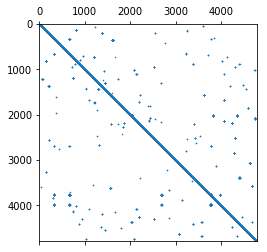

In [5]:
plt.spy(T, markersize = 0.5)

In [6]:
nodes

NameError: name 'nodes' is not defined

In [7]:
len(all_paths) == len(OD)

True

In [11]:
list(all_paths.keys())[:5]

[('RW@20:26:00', 'RF@20:53:00'),
 ('RF@20:55:00', 'RO@21:25:00'),
 ('RO@21:27:00', 'RAP@21:31:00'),
 ('RO@21:27:00', 'RBB@21:41:00'),
 ('RAP@21:31:00', 'RBB@21:41:00')]

In [12]:
list(OD.keys())[:5]

[('RW@20:26:00', 'RF@20:53:00'),
 ('RF@20:55:00', 'RO@21:25:00'),
 ('RO@21:27:00', 'RAP@21:31:00'),
 ('RO@21:27:00', 'RBB@21:41:00'),
 ('RAP@21:31:00', 'RBB@21:41:00')]

In [13]:
list(all_paths.keys()) == list(OD.keys())

True

In [14]:
count = 0
for u, v in list(OD.keys()):
    if u == v:
        count+=1

In [15]:
count

0

In [16]:
# try to find the number of waiting edges. i.e. number of edges that have same station but different times
count = 0
for u,v in list(OD.keys()):
    station1, time1 = u.split('@')
    station2, time2 = v.split('@')
    if station1 == station2:
        count+=1

    

In [17]:
count

135

In [20]:
graph

In [22]:
list(graph.edges())

[('RW@20:26:00', 'RF@20:53:00'),
 ('RF@20:55:00', 'RO@21:25:00'),
 ('RO@21:27:00', 'RAP@21:31:00'),
 ('RAP@21:31:00', 'RBB@21:41:00'),
 ('RBB@21:43:00', 'RDRM@21:53:00'),
 ('RDRM@21:53:00', 'RK@21:59:00'),
 ('RDRM@21:53:00', 'sink_0'),
 ('RK@22:01:00', 'RGN@22:10:00'),
 ('RGN@22:10:00', 'RSAB@22:12:00'),
 ('RSAB@22:12:00', 'RP@22:20:00'),
 ('RP@22:20:00', 'RM@22:24:00'),
 ('RM@22:36:00', 'FLP@22:44:00'),
 ('FLP@22:44:00', 'FGE@22:54:00'),
 ('FGE@22:54:00', 'FNI@23:10:00'),
 ('FNI@23:10:00', 'FF@23:15:00'),
 ('FLP@07:19:00', 'RM@07:27:00'),
 ('RM@07:36:00', 'RP@07:40:00'),
 ('RP@07:40:00', 'RSAB@07:48:00'),
 ('RSAB@07:48:00', 'RGN@07:50:00'),
 ('RGN@07:50:00', 'RK@07:58:00'),
 ('RK@08:00:00', 'RDRM@08:07:00'),
 ('RK@08:00:00', 'RGN@08:10:00'),
 ('RDRM@08:07:00', 'RBB@08:15:00'),
 ('RDRM@08:07:00', 'sink_0'),
 ('RBB@08:15:00', 'RAP@08:24:00'),
 ('RAP@08:24:00', 'RO@08:27:00'),
 ('RO@08:29:00', 'RF@08:59:00'),
 ('RF@09:01:00', 'RW@09:32:00'),
 ('RW@09:32:00', 'RB@09:34:00'),
 ('RB@09:41:0

In [24]:
graph.edges['FLP@22:44:00', 'FGE@22:54:00']['travel_time']

10

In [26]:
for u,v in list(graph.edges())[1:5]:
    print(u+'   '+v)

RF@20:55:00   RO@21:25:00
RO@21:27:00   RAP@21:31:00
RAP@21:31:00   RBB@21:41:00
RBB@21:43:00   RDRM@21:53:00


In [27]:
# Input: Data file in Forward Star format
# Output: Digraph object
# Function: This file will be used to read in information to
# create the DiGraph object and write it to another file
# @author: Ruby Abrams, Hai Nguyen

import sys

# change local PATH environment for Python
sys.path.append('/nfs/optimi/usr/sw/cplex/python/3.6/x86-64_linux')

import cplex
import networkx as nx
import time
import re
from scipy import *
from scipy.sparse import *
import numpy as np
#import Logger  # print out to file
from datetime import datetime, timedelta
from dateutil.parser import parse
import matplotlib.pyplot as plt
import pandas as pd

from copy import deepcopy

# from tools import *
from OD_matrix import *

# networkx start
graph = nx.DiGraph() # nx.MultiDiGraph()

inspectors = { 0 : {"base": 'RDRM', "working_hours": 8, "rate": 12},
              1 : {"base": 'HH', "working_hours": 5, "rate": 10},
              2 : {"base": 'AHAR', "working_hours": 6, "rate": 15}}
# Assumption: rate of inspection remains constant
KAPPA = 12
flow_var_names = []

# dictionary with keys being var_M and values being upper-bounds
var_passengers_inspected = {}
# new reformulation variable
var_portion_of_passengers_inspected = np.array([])

HOUR_TO_SECONDS = 3600
MINUTE_TO_SECONDS = 60


input_dir =  '../Nate/Small_Train_Schedule.txt'#'../hai_code/Mon_Arcs.txt' # /home/optimi/bzfnguye/grips-2019

#============================= CONSTRUCTING THE GRAPH ============================================

print("Building graph ...", end = " ")
t1 = time.time()

# build_graph(input_dir, graph, inspectors, flow_var_names, var_passengers_inspected)

with open(input_dir, "r") as f:
    for line in f.readlines()[:-1]:
        line = line.replace('\n','').split(' ')
        start = line[0]+'@'+line[1]
        end = line[2]+'@'+line[3]

        for k in inspectors:
            flow_var_names.append('var_x_{}_{}_{}'.format(start, end, k))

        var_passengers_inspected['var_M_{}_{}'.format(start, end)] = int(line[4])

        graph.add_node(start, station = line[0], time_stamp = line[1])
        graph.add_node(end, station = line[2], time_stamp = line[3])

        # we assume a unique edge between events for now
        if not graph.has_edge(start, end):
            graph.add_edge(start, end, num_passengers= int(line[4]), travel_time =int(line[5]))


# time to build graph
t2 = time.time()

print('Finished! Took {:.5f} seconds'.format(t2-t1))

#================================ OD Estimation ===============================
print("Estimating OD Matrix ...", end = " ")

# create a deep copy of the graph
new_graph = deepcopy(graph)

shortest_paths, arc_paths = create_arc_paths(new_graph)

T, OD = generate_OD_matrix(new_graph, shortest_paths, arc_paths)


# Create a dictionary
all_paths = {}
for source, value in shortest_paths.items():
    for sink, path in value.items():
        # exclude paths from nodes to themselves
        if source != sink and OD[(source, sink)] != 0:
            all_paths[(source, sink)] = path
path_idx = {path:i for i,path in enumerate(all_paths)}

# # preliminary data needed
# all_paths, path_idx = enumerate_all_shortest_paths(OD, shortest_paths)

t2a = time.time()
# print(new_weights)
print('Finished! Took {:.5f} seconds'.format(t2a-t2))

#============================== ADDING SOURCE/SINK NODES ==========================================

print("Adding Sinks/Sources...", end=" ")

# add_sources_and_sinks(graph, inspectors, flow_var_names, var_passengers_inspected)
for k, vals in inspectors.items():
    source = "source_" + str(k)
    sink = "sink_"+str(k)
    graph.add_node(source, station = vals['base'], time_stamp = None)
    graph.add_node(sink, station = vals['base'], time_stamp = None)
    for node in graph.nodes():
        if (graph.nodes[node]['station'] == vals['base']) and (graph.nodes[node]['time_stamp'] is not None):

            # adding edge between sink and events and adding to the variable dictionary
            graph.add_edge(source, node, num_passengers = 0, travel_time = 0)
            flow_var_names.append('var_x_{}_{}_{}'.format(source, node, k))
            var_passengers_inspected['var_M_{}_{}'.format(source, node)] = 0
            graph.add_edge(node, sink, num_passengers=0, travel_time = 0 )
            flow_var_names.append('var_x_{}_{}_{}'.format(node, sink, k))
            var_passengers_inspected['var_M_{}_{}'.format(node, sink)] = 0


t3 = time.time()

print('Finished! Took {:.5f} seconds'.format(t3-t2a))

# test edge source to sinks
# print('TEST: Unique edge between two nodes: ', num_edges == graph.number_of_edges())
print("TEST: No Source-Sink Edge: ", not graph.has_edge("source_0", "sink_0"))

# freeze graph to prevent further changes
graph = nx.freeze(graph)

#print('successors of FFU@10:51:00')

#count = 0
#for edge in graph.edges():
    #if edge['num_passengers'] == 0:
        #count+=1
#print('num edges: {}'.format(count))

#================================== START CPLEX =================================================

print("Start CPLEX")

c = cplex.Cplex()

# start_cplex(c, flow_var_names, var_passengers_inspected)
# initialize_cplex(c, OD, flow_var_names, var_portion_of_passengers_inspected)
c.set_problem_type(c.problem_type.LP)
c.objective.set_sense(c.objective.sense.maximize)	# formulated as a maximization problem


#========================= ADDING VARIABLES AND OBJECTIVE FUNCTION ==============================

print("Adding variables...", end=" ")

# adding objective function and declaring variable types
c.variables.add(
    names = flow_var_names,
    types = [ c.variables.type.binary ] * len(flow_var_names)
)

# create variable names
for (source, sink), value in all_paths.items():
    var_portion_of_passengers_inspected = np.append(var_portion_of_passengers_inspected, 'portion_of_({},{})'.format(source, sink))

# defining the objective function coefficients
#obj = [OD[(source, sink)] for source, sink in OD.keys()]

c.variables.add(
    names = var_portion_of_passengers_inspected,
    lb = [0] * len(var_portion_of_passengers_inspected),
    ub = [1] * len(var_portion_of_passengers_inspected),
    obj = OD.values(),
    types = [ c.variables.type.continuous ] * len(var_portion_of_passengers_inspected)
)

t4 = time.time()
print("Finished! Took {:.5f} seconds".format(t4-t3))

#=================================== CONSTRAINT 6 ===================================================

print("Adding Constraint (6)...", end=" ")

# constr_mass_balance(c, graph, inspectors)
for k in inspectors:
    for node in graph.nodes():
        if graph.nodes[node]['time_stamp']:

            in_indices = []

            for p in graph.predecessors(node):
                in_indices.append('var_x_{}_{}_{}'.format(p, node, k))
            in_vals = [1] * len(in_indices)

            out_indices = []

            for p in graph.successors(node):
                out_indices.append('var_x_{}_{}_{}'.format(node, p, k))

            out_vals = [-1] * len(out_indices)

            c.linear_constraints.add(
                lin_expr = [cplex.SparsePair(
                                ind = in_indices + out_indices,
                                val = in_vals + out_vals
                            )],
                senses = ['E'],
                rhs = [0],
                names = ['mass_balance_constr_{}_{}'.format(node, k)]
            )


t5 = time.time()

print('Finished! Took {:.5f} seconds'.format(t5-t4))


#=================================== CONSTRAINT 7 ===============================================

print("Adding constraint (7) ...", end=" ")

# constr_sink_source(c, graph, inspectors)
for k, vals in inspectors.items():
    sink = "sink_" + str(k)
    source = "source_" + str(k)

    c.linear_constraints.add(
        lin_expr = [cplex.SparsePair(
                        ind = ['var_x_{}_{}_{}'.format(u, sink, k) for u in graph.predecessors(sink)],
                        val = [1] * graph.in_degree(sink)
                    )],
        senses = ['E'],
        rhs = [1],
        names = ['sink_constr_{}'.format(k)]
    )

    c.linear_constraints.add(
        lin_expr = [ cplex.SparsePair(
                        ind = ['var_x_{}_{}_{}'.format(source, u, k) for u in graph.successors(source)] ,
                        val = [1] * graph.out_degree(source)
                    )],
        senses = ['E'],
        rhs = [1],
        names = ['source_constr_{}'.format(k)]
    )

t6 = time.time()
print('Finished! Took {:.5f} seconds'.format(t6-t5))


#===================================== CONSTRAINT 8 ==================================================

print("Adding Constraint (8)...", end=" ")

# constr_working_hours(c, graph, inspectors)
for k, vals in inspectors.items():
    source = "source_" + str(k) + ""
    sink = "sink_" + str(k)
    c.linear_constraints.add(
        lin_expr = [cplex.SparsePair(
                    ind = ['var_x_{}_{}_{}'.format(u, sink, k) for u in graph.predecessors(sink)]
                        + ['var_x_{}_{}_{}'.format(source, v, k) for v in graph.successors(source)],
                    val = [time.mktime(parse(graph.nodes[u]['time_stamp']).timetuple())
                                    for u in graph.predecessors(sink)]
                        + [-time.mktime(parse(graph.nodes[v]['time_stamp']).timetuple())
                                    for v in graph.successors(source)]
                        )],
        senses = ['L'],
        rhs = [vals['working_hours'] * HOUR_TO_SECONDS],
        names = ['time_flow_constr_{}'.format(k)]
    )

t7 = time.time()
print("Finished! Took {:.5f} seconds".format(t7-t6))


#================================== CONSTRAINT 9 ==========================================

print('Adding Constraint (9)...', end = " ")

# new constraint
# constr_reformulated(c, graph, inspectors, arc_paths)

for (u, v), path in all_paths.items():
    if not ("source_" in u+v or "sink_" in u+v):
        indices = ['portion_of_({},{})'.format(u,v)] + ['var_x_{}_{}_{}'.format(i,j,k) for k in inspectors for i,j in zip(path, path[1:])]
        values = [1] + [-KAPPA * graph.edges[i,j]['travel_time']/graph.edges[i,j]['num_passengers'] for k in inspectors for i,j in zip(path, path[1:])]
        c.linear_constraints.add(
            lin_expr = [cplex.SparsePair(ind = indices, val = values)], # needs to be checked
            senses = ['L'],
            rhs = [0],
            range_values = [0],
            names = ['bdd_by_inspector_count_{}_{}'.format(u, v)]
        )
# old constraint
# constraint_9(c, graph, inspectors)

t8 = time.time()
print("Finished! Took {:.5f} seconds".format(t8-t7))


#================================== POST-PROCESSING ================================================

print('Write to inspectors.lp ...', end=" ")
c.write('inspectors.lp')
t9 =time.time()
print('Finished! Took {:.5f} seconds'.format(t9-t8))


print("Now solving ...", end = " ")
c.solve()
print("Solution Status: ", c.solution.get_status())
t10 = time.time()
print('Finished! Took {:.5f} seconds'.format(t10-t9))
print("Print out solutions:")

try:
    res = c.solution.get_values( flow_var_names )
    #print(res)
except cplex.exceptions.errors.CplexSolverError:
    print("No solution exists.")

print("Test: Do 'flow_var_names' and 'res' have same size? ", len(flow_var_names)==len(res))

# post-processing
paths = [re.split('_|\^|@', edge)[2:] for edge, x_val in zip(flow_var_names, res) if x_val]

print("Edges Number = ", len(paths))

#for edge in paths:
    #print(edge)

df_paths = pd.DataFrame(paths, columns=['from_station', 'departure_time', 'to_station', 'arrival_time', 'inspector_id'])

#df_paths['inspector_id'].astype('int8')

for k, vals in inspectors.items():
    print("Solution for Inspector ", k)
    path = df_paths[df_paths['inspector_id'] == str(k)]
    path = path.sort_values(by=['departure_time'])
    print(path.to_string())
    path.to_csv('inspector_0_path.csv', index = False)

#print(len(paths))


t11= time.time()
print("Programme Terminated! Took {:.5f} seconds".format(t11-t1))

#print(flow_var_names[:10])


Building graph ... Finished! Took 0.00110 seconds
Estimating OD Matrix ... 

TypeError: generate_OD_matrix() takes 1 positional argument but 3 were given

In [11]:
# Input: Data file in Forward Star format
# Output: Digraph object
# Function: This file will be used to read in information to
# create the DiGraph object and write it to another file
# @author: Ruby Abrams, Hai Nguyen, Nate May

from __future__ import division

import sys

# change local PATH environment for Python
sys.path.append('/nfs/optimi/usr/sw/cplex/python/3.6/x86-64_linux')

import cplex
import networkx as nx
import time
import re
from scipy import *
from scipy.sparse import *
import numpy as np
#import Logger  # print out to file
from datetime import datetime, timedelta
from dateutil.parser import parse
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

from OD_matrix import *

# networkx start
graph = nx.DiGraph() # nx.MultiDiGraph()

inspectors = { 0 : {"base": 'RDRM', "working_hours": 8, "rate": 12},
              1 : {"base": 'HH', "working_hours": 5, "rate": 10},
              2 : {"base": 'AHAR', "working_hours": 6, "rate": 15}}

#inspectors = {0: {"base": 'C', "working_hours":1},
              #1: {"base": 'A', "working_hours":1}}
# Assumption: rate of inspection remains constant
KAPPA = 12
flow_var_names = []

# new reformulation variable
var_portion_of_passengers_inspected = np.array([])

HOUR_TO_SECONDS = 3600
MINUTE_TO_SECONDS = 60


input_dir = '../hai_code/Mon_Arcs.txt' # /home/optimi/bzfnguye/grips-2019
#input_dir = '../Nate/Small_Train_Schedule.txt'

#============================= CONSTRUCTING THE GRAPH ============================================

print("Building graph ...", end = " ")
t1 = time.time()

with open(input_dir, "r") as f:
    for line in f.readlines()[:-1]:
        line = line.replace('\n','').split(' ')
        start = line[0]+'@'+line[1]
        end = line[2]+'@'+line[3]

        for k in inspectors:
            flow_var_names.append('var_x_{}_{}_{}'.format(start, end, k))

        graph.add_node(start, station = line[0], time_stamp = line[1])
        graph.add_node(end, station = line[2], time_stamp = line[3])

        # we assume a unique edge between events for now
        if not graph.has_edge(start, end):
            graph.add_edge(start, end, num_passengers= int(line[4]), travel_time =int(line[5]))


# time to build graph
t2 = time.time()

print('Finished! Took {:.5f} seconds'.format(t2-t1))

#================================ OD Estimation ===============================
print("Estimating OD Matrix ...", end = " ")

# create a deep copy of the graph
new_graph = deepcopy(graph)

nodes = graph.nodes()

shortest_paths, arc_paths = create_arc_paths(new_graph)

T, OD = generate_OD_matrix(nodes, shortest_paths, arc_paths)

# Create a dictionary of all Origin-Destinations
all_paths = {}
# for source, value in shortest_paths.items():
#     for sink, path in value.items():
#         # exclude paths from nodes to themselves
#         if source != sink and OD[(source, sink)] > 0.001:
#             all_paths[(source, sink)] = path
for source, sink in OD.keys():
    if source != sink:
        all_paths[(source, sink)] = shortest_paths[source][sink]
path_idx = {path:i for i,path in enumerate(all_paths)}


t2a = time.time()
print('Finished! Took {:.5f} seconds'.format(t2a-t2))

#============================== ADDING SOURCE/SINK NODES ==========================================

print("Adding Sinks/Sources...", end=" ")

for k, vals in inspectors.items():
    source = "source_" + str(k)
    sink = "sink_"+str(k)
    graph.add_node(source, station = vals['base'], time_stamp = None)
    graph.add_node(sink, station = vals['base'], time_stamp = None)
    for node in graph.nodes():
        if (graph.nodes[node]['station'] == vals['base']) and (graph.nodes[node]['time_stamp'] is not None):
            # adding edge between sink and events and adding to the variable dictionary
            graph.add_edge(source, node, num_passengers = 0, travel_time = 0)
            flow_var_names.append('var_x_{}_{}_{}'.format(source, node, k))
            graph.add_edge(node, sink, num_passengers=0, travel_time = 0 )
            flow_var_names.append('var_x_{}_{}_{}'.format(node, sink, k))


t3 = time.time()

print('Finished! Took {:.5f} seconds'.format(t3-t2a))

# test edge source to sinks
# print('TEST: Unique edge between two nodes: ', num_edges == graph.number_of_edges())
print("TEST: No Source-Sink Edge: ", not graph.has_edge("source_0", "sink_0"))

# freeze graph to prevent further changes
graph = nx.freeze(graph)

#================================== START CPLEX =================================================
#                           Establish Maximization Problem
#================================================================================================

print("Start CPLEX")

c = cplex.Cplex()
c.set_problem_type(c.problem_type.LP)
c.objective.set_sense(c.objective.sense.maximize)	# formulated as a maximization problem


#========================= ADDING VARIABLES AND OBJECTIVE FUNCTION ==============================

print("Adding variables...", end=" ")

# declaring variable types for binary variables
c.variables.add(
    names = flow_var_names,
    types = [ c.variables.type.binary ] * len(flow_var_names)
)

# create variable names
for (source, sink) in all_paths.keys():
    var_portion_of_passengers_inspected = np.append(var_portion_of_passengers_inspected, 'portion_of_({},{})'.format(source, sink))


# Adding the objective function coefficients
c.variables.add(
    names = var_portion_of_passengers_inspected,
    lb = [0] * len(var_portion_of_passengers_inspected),
    ub = [1] * len(var_portion_of_passengers_inspected),
    obj = list(OD.values()),
    types = [ c.variables.type.continuous ] * len(var_portion_of_passengers_inspected)
)

t4 = time.time()
print("Finished! Took {:.5f} seconds".format(t4-t3))

#=================================== CONSTRAINT 6 ===================================================
#                              Mass - Balance Constraint
#================================================================================================
print("Adding Constraint (6) [Mass - Balance Constraint] ...", end=" ")

for k in inspectors:
    for node in graph.nodes():
        if graph.nodes[node]['time_stamp']:

            in_indices = []

            for p in graph.predecessors(node):
                if graph.nodes[p]['time_stamp'] or p.split('_')[1] == str(k): # not a sink/source
                    in_indices.append('var_x_{}_{}_{}'.format(p, node, k))
            in_vals = [1] * len(in_indices)

            out_indices = []

            for p in graph.successors(node):
                if graph.nodes[p]['time_stamp'] or p.split('_')[1] == str(k):
                    out_indices.append('var_x_{}_{}_{}'.format(node, p, k))

            out_vals = [-1] * len(out_indices)

            c.linear_constraints.add(
                lin_expr = [cplex.SparsePair(
                                ind = in_indices + out_indices,
                                val = in_vals + out_vals
                            )],
                senses = ['E'],
                rhs = [0],
                names = ['mass_balance_constr_{}_{}'.format(node, k)]
            )

t5 = time.time()

print('Finished! Took {:.5f} seconds'.format(t5-t4))


#=================================== CONSTRAINT 7 ===============================================
#                              Sink and Source Constraint
#================================================================================================

print("Adding constraint (7) [Sink and Source Constraint]...", end=" ")

for k, vals in inspectors.items():
    sink = "sink_" + str(k)
    source = "source_" + str(k)

    c.linear_constraints.add(
        lin_expr = [cplex.SparsePair(
                        ind = ['var_x_{}_{}_{}'.format(u, sink, k) for u in graph.predecessors(sink)],
                        val = [1] * graph.in_degree(sink)
                    )],
        senses = ['E'],
        rhs = [1],
        names = ['sink_constr_{}'.format(k)]
    )

    c.linear_constraints.add(
        lin_expr = [ cplex.SparsePair(
                        ind = ['var_x_{}_{}_{}'.format(source, u, k) for u in graph.successors(source)] ,
                        val = [1] * graph.out_degree(source)
                    )],
        senses = ['E'],
        rhs = [1],
        names = ['source_constr_{}'.format(k)]
    )

t6 = time.time()
print('Finished! Took {:.5f} seconds'.format(t6-t5))


#===================================== CONSTRAINT 8 ==================================================
#                        Time Flow/Number of Working Hours Constraint
#================================================================================================

print("Adding Constraint (8)[Time Flow Constraint]...", end=" ")

for k, vals in inspectors.items():
    source = "source_" + str(k) + ""
    sink = "sink_" + str(k)
    c.linear_constraints.add(
        lin_expr = [cplex.SparsePair(
                    ind = ['var_x_{}_{}_{}'.format(u, sink, k) for u in graph.predecessors(sink)]
                        + ['var_x_{}_{}_{}'.format(source, v, k) for v in graph.successors(source)],
                    val = [time.mktime(parse(graph.nodes[u]['time_stamp']).timetuple())
                                    for u in graph.predecessors(sink)]
                        + [-time.mktime(parse(graph.nodes[v]['time_stamp']).timetuple())
                                    for v in graph.successors(source)]
                        )],
        senses = ['L'],
        rhs = [vals['working_hours'] * HOUR_TO_SECONDS],
        names = ['time_flow_constr_{}'.format(k)]
    )

t7 = time.time()
print("Finished! Took {:.5f} seconds".format(t7-t6))


#================================== CONSTRAINT 9 ==========================================
#                   Minimum Constraint (Linearizing the Objective Function)
#================================================================================================

print('Adding Constraint (9)[Minimum Constraint]...', end = " ")

for (u, v), path in all_paths.items():
    if not ("source_" in u+v or "sink_" in u+v):
        indices = ['portion_of_({},{})'.format(u,v)] + ['var_x_{}_{}_{}'.format(i,j,k) for i,j in zip(path, path[1:]) for k in inspectors]
        values = [1] + [-KAPPA * graph.edges[i,j]['travel_time']/graph.edges[i,j]['num_passengers'] for i,j in zip(path, path[1:]) for k in inspectors]
        c.linear_constraints.add(
            lin_expr = [cplex.SparsePair(ind = indices, val = values)], # needs to be checked
            senses = ['L'],
            rhs = [0],
            # range_values = [0],
            names = ['percentage_inspected_on_({},{})'.format(u, v)]
        )

t8 = time.time()
print("Finished! Took {:.5f} seconds".format(t8-t7))


#================================== POST-PROCESSING ================================================

print('Write to inspectors.lp ...', end=" ")
c.write('inspectors.lp')
t9 =time.time()
print('Finished! Took {:.5f} seconds'.format(t9-t8))


print("Now solving ...", end = " ")
c.solve()
print("Solution Status: ", c.solution.get_status())
t10 = time.time()
print('Finished! Took {:.5f} seconds'.format(t10-t9))
print("Print out solutions:")

try:
    res = c.solution.get_values( flow_var_names )
    #print(res)
except cplex.exceptions.errors.CplexSolverError:
    print("No solution exists.")

print("Test: Do 'flow_var_names' and 'res' have same size? ", len(flow_var_names)==len(res))

# post-processing
paths = [re.split('_|\^|@', edge)[2:] for edge, x_val in zip(flow_var_names, res) if x_val]

print("Edges Number = ", len(paths))

#for edge in paths:
    #print(edge)

df_paths = pd.DataFrame(paths, columns=['from_station', 'departure_time', 'to_station', 'arrival_time', 'inspector_id'])

#df_paths['inspector_id'].astype('int8')

for k, vals in inspectors.items():
    print("Solution for Inspector ", k)
    path = df_paths[df_paths['inspector_id'] == str(k)]
    path = path.sort_values(by=['departure_time'])
    print(path.to_string())
    path.to_csv('inspector_0_path.csv', index = False)

#print(len(paths))


t11= time.time()
print("Programme Terminated! Took {:.5f} seconds".format(t11-t1))

#print(flow_var_names[:10])


Building graph ... Finished! Took 0.14868 seconds
Estimating OD Matrix ... Finished! Took 37.80439 seconds
Adding Sinks/Sources... Finished! Took 0.02832 seconds
TEST: No Source-Sink Edge:  True
Start CPLEX
Adding variables... Finished! Took 3.36126 seconds
Adding Constraint (6) [Mass - Balance Constraint] ... Finished! Took 8.74685 seconds
Adding constraint (7) [Sink and Source Constraint]... Finished! Took 0.00632 seconds
Adding Constraint (8)[Time Flow Constraint]... Finished! Took 0.04162 seconds
Adding Constraint (9)[Minimum Constraint]... 

Finished! Took 9.73763 seconds
Write to inspectors.lp ... 

CPLEX Error  1016: Community Edition. Problem size limits exceeded. Purchase at https://ibm.co/2s0wqSa.


Finished! Took 1.16573 seconds
Now solving ... 

CplexSolverError: CPLEX Error  1016: Community Edition. Problem size limits exceeded. Purchase at https://ibm.co/2s0wqSa.

In [6]:
len(OD)

10580

In [7]:
len(var_portion_of_passengers_inspected)

8657

In [4]:
len(all_paths)

8657

In [8]:
shortest_paths

{'XSZH@19:00:00': {'XSZH@19:00:00': ['XSZH@19:00:00']},
 'XSB@19:53:00': {'XSB@19:53:00': ['XSB@19:53:00']},
 'XSB@20:13:00': {'XSB@20:13:00': ['XSB@20:13:00']},
 'RXBA@20:17:00': {'RXBA@20:17:00': ['RXBA@20:17:00']},
 'RB@20:19:00': {'RB@20:19:00': ['RB@20:19:00']},
 'RB@20:23:00': {'RB@20:23:00': ['RB@20:23:00']},
 'RW@20:26:00': {'RW@20:26:00': ['RW@20:26:00'],
  'RF@20:53:00': ['RW@20:26:00', 'RF@20:53:00']},
 'RF@20:53:00': {'RF@20:53:00': ['RF@20:53:00']},
 'RF@20:55:00': {'RF@20:55:00': ['RF@20:55:00'],
  'RO@21:25:00': ['RF@20:55:00', 'RO@21:25:00']},
 'RO@21:25:00': {'RO@21:25:00': ['RO@21:25:00']},
 'RO@21:27:00': {'RO@21:27:00': ['RO@21:27:00'],
  'RAP@21:31:00': ['RO@21:27:00', 'RAP@21:31:00'],
  'RBB@21:41:00': ['RO@21:27:00', 'RAP@21:31:00', 'RBB@21:41:00']},
 'RAP@21:31:00': {'RAP@21:31:00': ['RAP@21:31:00'],
  'RBB@21:41:00': ['RAP@21:31:00', 'RBB@21:41:00']},
 'RBB@21:41:00': {'RBB@21:41:00': ['RBB@21:41:00']},
 'RBB@21:43:00': {'RBB@21:43:00': ['RBB@21:43:00'],
  'RDR

In [9]:
OD

{('RW@20:26:00', 'RF@20:53:00'): 256.0,
 ('RF@20:55:00', 'RO@21:25:00'): 415.0,
 ('RO@21:27:00', 'RAP@21:31:00'): 22.0,
 ('RO@21:27:00', 'RBB@21:41:00'): 394.0,
 ('RAP@21:31:00', 'RBB@21:41:00'): 18.0,
 ('RBB@21:43:00', 'RDRM@21:53:00'): 11.0,
 ('RBB@21:43:00', 'RK@21:59:00'): 402.0,
 ('RDRM@21:53:00', 'RK@21:59:00'): 37.0,
 ('RK@22:01:00', 'RGN@22:10:00'): 19.0,
 ('RK@22:01:00', 'RSAB@22:12:00'): 20.0,
 ('RK@22:01:00', 'RP@22:20:00'): 109.0,
 ('RK@22:01:00', 'RM@22:24:00'): 290.0,
 ('RGN@22:10:00', 'RSAB@22:12:00'): 1.0,
 ('RGN@22:10:00', 'RP@22:20:00'): 6.0,
 ('RGN@22:10:00', 'RM@22:24:00'): 15.0,
 ('RSAB@22:12:00', 'RP@22:20:00'): 6.0,
 ('RSAB@22:12:00', 'RM@22:24:00'): 15.0,
 ('RP@22:20:00', 'RM@22:24:00'): 3.0,
 ('RM@22:36:00', 'FLP@22:44:00'): 17.0,
 ('RM@22:36:00', 'FGE@22:54:00'): 17.0,
 ('RM@22:36:00', 'FNI@23:10:00'): 81.0,
 ('RM@22:36:00', 'FF@23:15:00'): 207.0,
 ('FLP@22:44:00', 'FGE@22:54:00'): 1.0,
 ('FLP@22:44:00', 'FNI@23:10:00'): 5.0,
 ('FLP@22:44:00', 'FF@23:15:00'): 

In [10]:
for source, sink in OD.keys():
    if source == sink:
        print(OD[(source, sink)])
        